In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#Training algorithms import
import xgboost as xgb 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



plt.style.use("fivethirtyeight")

# Evaluation and training imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [8]:
df = pd.read_csv("..\data\sensor_data.csv", parse_dates=True, header=None) #, index_col="Datetime"
df.columns = ["Datetime","Temperature", "Humidity" , "Pressure", "Altitude" ,"CO" ,"CO2" ,"NH4", "PM1.0" ,"PM2.5", "PM10.0"]
df['Datetime'] = pd.to_datetime(df["Datetime"], format='%Y-%m-%d %H:%M:%S')

quantities = ['Temperature', 'Rel. Humidity', 'Pressure', 'CO', r'CO$_2$', r'NH$_3$', r'PM$_{1}$', 
                  'PM$_{2.5}$', 'PM$_{10}$']
units = [r'$^o$C','%', 'hPa','ppm','ppm','ppm',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ']
df = df.set_index("Datetime")
df['Pressure'] = df['Pressure']/100

## For PM10.0

In [9]:
# Adding an hour feature to the dataset 
df["hour"] = df.index.hour

<AxesSubplot: title={'center': 'Particulate Matter 10.0 [$\\mu g/m^3$ ]'}, xlabel='Datetime'>

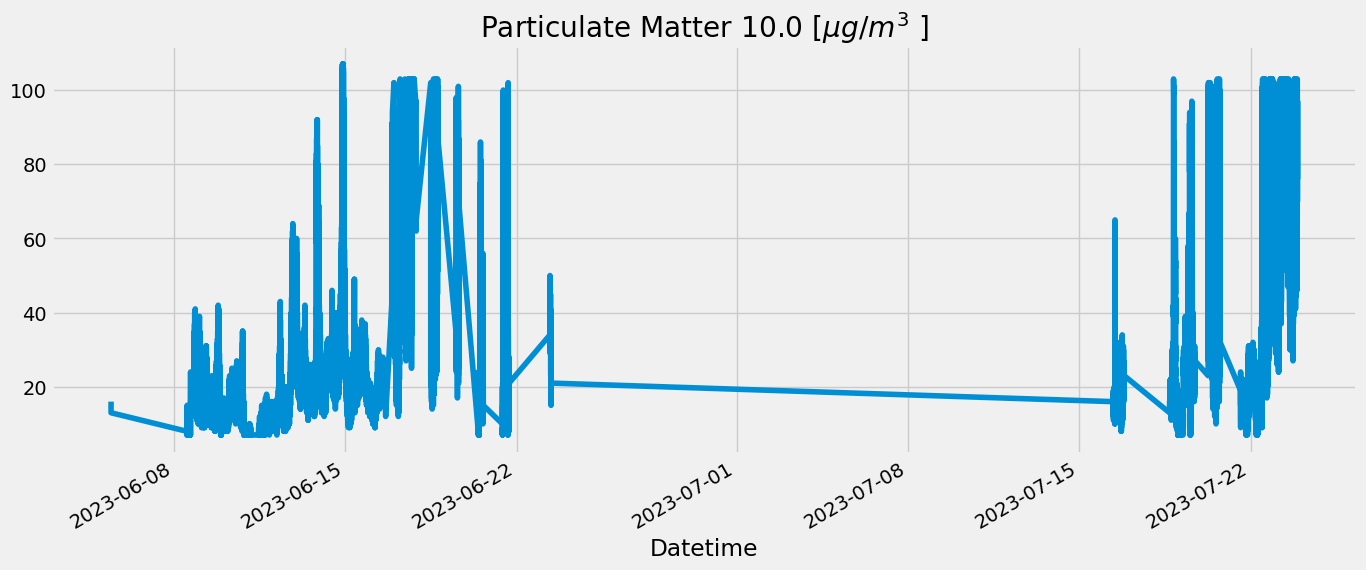

In [10]:
df["PM10.0"].plot(figsize=(15, 6), title=f"Particulate Matter 10.0 [{units[6]}]")

## Model Creation


### Train/ Test Split


In [11]:
#Splitting of train and test data
X = df.drop("PM10.0", axis=1)
y = df["PM10.0"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## XGBoost Linear Regression

In [12]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
xgb_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)],
             verbose=100)

[0]	validation_0-rmse:30.46791	validation_1-rmse:30.21019
[100]	validation_0-rmse:11.20784	validation_1-rmse:11.11957
[200]	validation_0-rmse:4.21843	validation_1-rmse:4.19223
[300]	validation_0-rmse:1.80798	validation_1-rmse:1.80597
[400]	validation_0-rmse:1.13608	validation_1-rmse:1.14506
[500]	validation_0-rmse:1.00300	validation_1-rmse:1.01670
[600]	validation_0-rmse:0.97604	validation_1-rmse:0.99352
[700]	validation_0-rmse:0.96699	validation_1-rmse:0.98750
[800]	validation_0-rmse:0.96188	validation_1-rmse:0.98522
[900]	validation_0-rmse:0.95850	validation_1-rmse:0.98391
[999]	validation_0-rmse:0.95513	validation_1-rmse:0.98273


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [13]:
pm10_0_model = joblib.dump(xgb_model, "new_trained/xgb_pm10_0.sav")

 ### Feature Importance

In [14]:
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=["importance"])

<AxesSubplot: title={'center': 'Feature Importance'}>

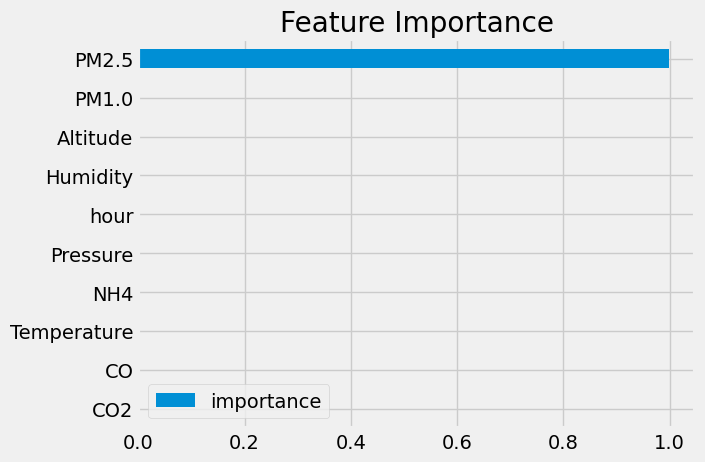

In [15]:
fi.sort_values('importance').plot(kind="barh", title="Feature Importance")

### Forecast on Test

In [16]:
# Forecasting previous values to see the performance of model
xgb_prediction = xgb_model.predict(X)
df["xgbpredict"] = xgb_prediction

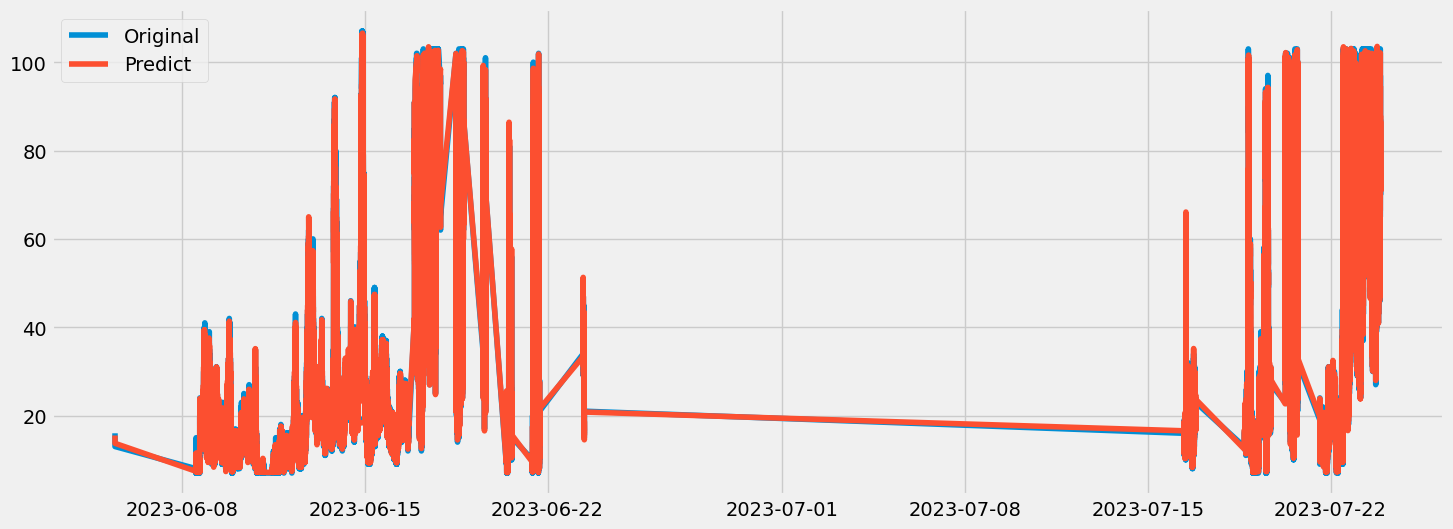

In [17]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM10.0"], label="Original")
ax.plot(df["xgbpredict"], label="Predict")


ax.legend()

### Evaluation Metric

In [18]:
#  Mean Squared Error
xgb_mse = mean_squared_error(df["PM10.0"], df["xgbpredict"])
xgb_mse

0.9202931633016207

In [19]:
#Root Mean Squared Error
xgb_rmse = np.sqrt(mean_squared_error(df["PM10.0"], df["xgbpredict"]))
xgb_rmse

0.9593191144252369

In [20]:
# Mean Absolute Error
xgb_mae = mean_absolute_error(df["PM10.0"], df["xgbpredict"])
xgb_mae

0.7241438825896171

In [21]:
xgb_err_eval = [xgb_mse, xgb_rmse, xgb_mae]
xgb_err_eval

[0.9202931633016207, 0.9593191144252369, 0.7241438825896171]

## Sklearn Linear Regression 

In [22]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)



LinearRegression()

In [23]:
linreg_model_sav = joblib.dump(linreg_model, "new_trained/linreg_pm10_0.sav")

### Forecast on Test

In [24]:
# Forecasting previous values to see the performance of model
linreg_prediction = linreg_model.predict(X)
df["linregpredict"] = linreg_prediction

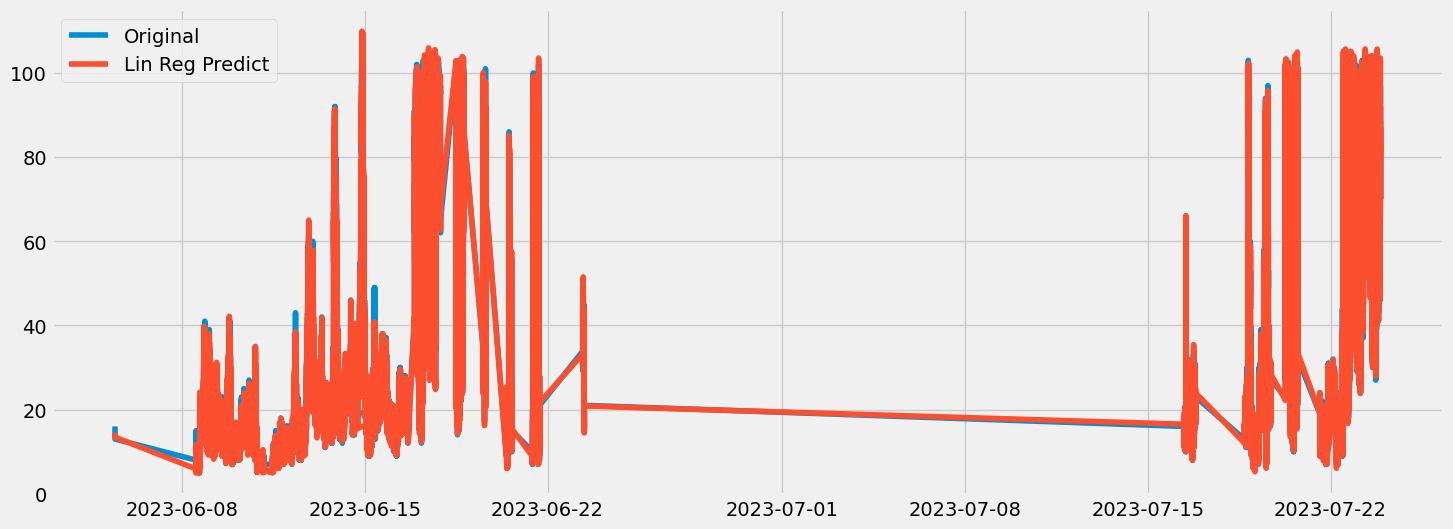

In [25]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM10.0"], label="Original")
ax.plot(df["linregpredict"], label="Lin Reg Predict")


ax.legend()

### Evaluation Metric

In [26]:
#  Mean Squared Error
linreg_mse = mean_squared_error(df["PM10.0"], df["linregpredict"])
linreg_mse

1.068354668520946

In [27]:
#Root Mean Squared Error
linreg_rmse = np.sqrt(mean_squared_error(df["PM10.0"], df["linregpredict"]))
linreg_rmse

1.0336124363226993

In [28]:
# Mean Absolute Error
linreg_mae = mean_absolute_error(df["PM10.0"], df["linregpredict"])
linreg_mae

0.7579808922243453

In [29]:
linreg_err_eval = [linreg_mse, linreg_rmse, linreg_mae]
linreg_err_eval

[1.068354668520946, 1.0336124363226993, 0.7579808922243453]

## Sklearn  Decision Tree Classifier

In [30]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)


DecisionTreeClassifier()

In [31]:
tree_model_sav = joblib.dump(tree_model, "new_trained/tree_pm10_0.sav")

### Forecast on Test

In [32]:
# Forecasting previous values to see the performance of model
tree_model_prediction = tree_model.predict(X)
df["treepredict"] = tree_model_prediction

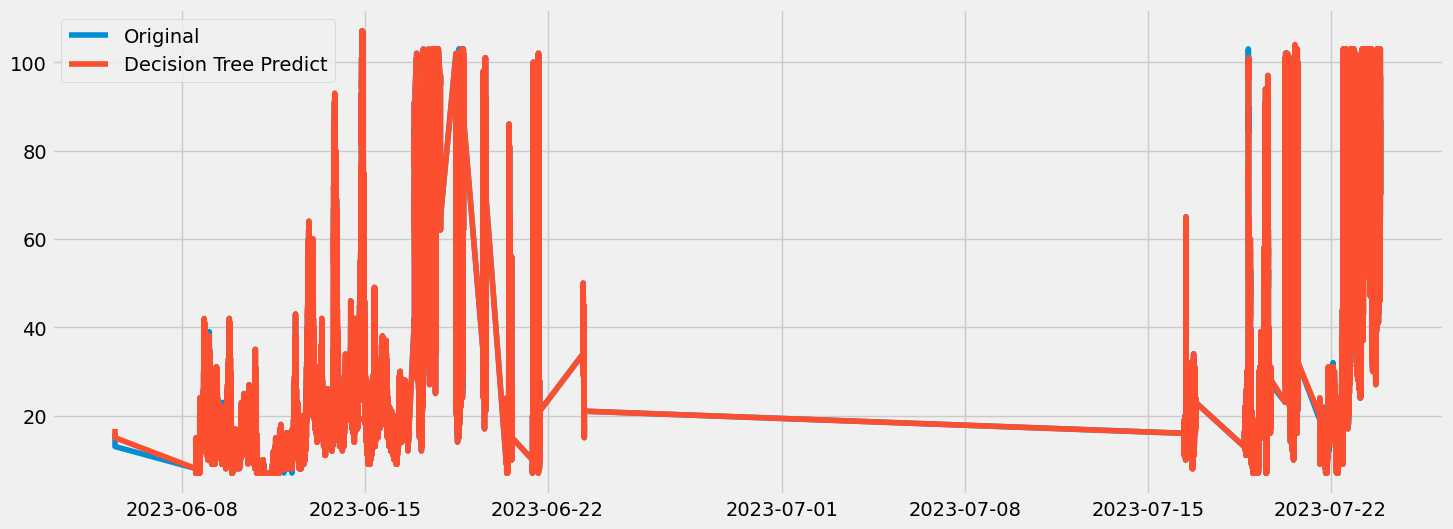

In [33]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM10.0"], label="Original")
ax.plot(df["treepredict"], label="Decision Tree Predict")


ax.legend()

### Evaluation Metric

In [34]:
#  Mean Squared Error
tree_model_mse = mean_squared_error(df["PM10.0"], df["treepredict"])
tree_model_mse

0.22818090266833743

In [35]:
#Root Mean Squared Error
tree_model_rmse = np.sqrt(mean_squared_error(df["PM10.0"], df["treepredict"]))
tree_model_rmse

0.4776828473666785

In [36]:
# Mean Absolute Error
tree_model_mae = mean_absolute_error(df["PM10.0"], df["treepredict"])
tree_model_mae

0.10259761225697835

In [37]:
tree_err_eval = [tree_model_mse, tree_model_rmse, tree_model_mae]
tree_err_eval

[0.22818090266833743, 0.4776828473666785, 0.10259761225697835]

## Sklearn  Decision Tree Regressor

In [38]:
tree_reg_model = DecisionTreeRegressor()
tree_reg_model.fit(X_train, y_train)



DecisionTreeRegressor()

In [39]:
tree_reg_model_sav = joblib.dump(tree_model, "new_trained/tree_reg_pm10_0.sav")

### Forecast on Test

In [40]:
# Forecasting previous values to see the performance of model
tree_reg_prediction = tree_reg_model.predict(X)
df["tree_reg_predict"] = tree_reg_prediction

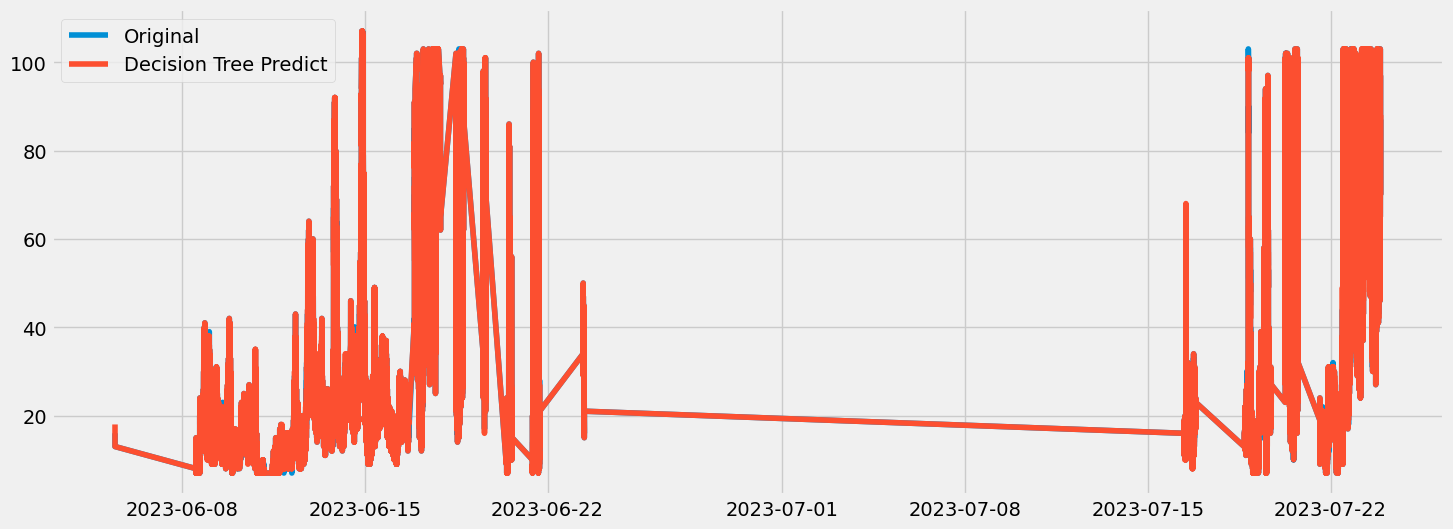

In [41]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM10.0"], label="Original")
ax.plot(df["tree_reg_predict"], label="Decision Tree Predict")


ax.legend()

### Evaluation Metric

In [42]:
#  Mean Squared Error
tree_reg_model_mse = mean_squared_error(df["PM10.0"], df["tree_reg_predict"])
tree_reg_model_mse

0.2290034670705176

In [43]:
#Root Mean Squared Error
tree_reg_model_rmse = np.sqrt(mean_squared_error(df["PM10.0"], df["tree_reg_predict"]))
tree_reg_model_rmse

0.47854306710108924

In [44]:
# Mean Absolute Error
tree_reg_model_mae = mean_absolute_error(df["PM10.0"], df["tree_reg_predict"])
tree_reg_model_mae

0.10285130034363205

In [45]:
tree_reg_err_eval = [tree_reg_model_mse, tree_reg_model_rmse, tree_reg_model_mae]
tree_reg_err_eval

[0.2290034670705176, 0.47854306710108924, 0.10285130034363205]

## Sklearn RandomForest Classifier

In [46]:
rforest_model = RandomForestClassifier()
rforest_model.fit(X_train, y_train)



RandomForestClassifier()

In [47]:
# rforest_model_sav = joblib.dump(rforest_model, "new_trained/rforest_pm10_0.sav")

### Forecast on Test

In [48]:
# Forecasting previous values to see the performance of model
rforest_prediction = rforest_model.predict(X)
df["rforestpredict"] = rforest_prediction

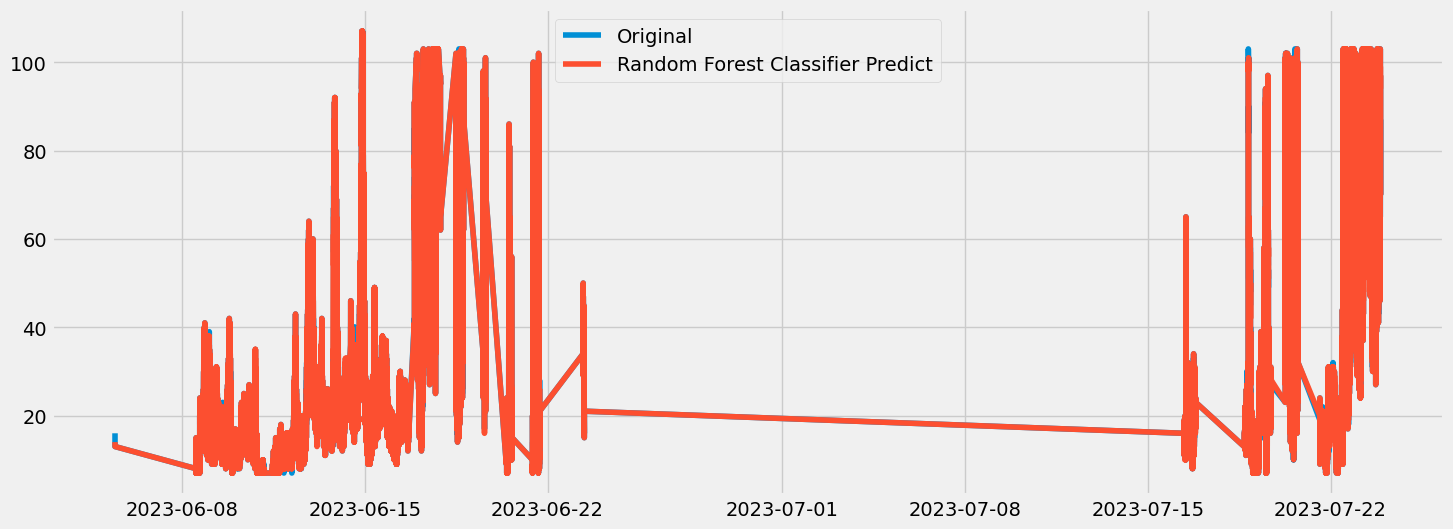

In [49]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM10.0"], label="Original")
ax.plot(df["rforestpredict"], label="Random Forest Classifier Predict")


ax.legend()

### Evaluation Metric

In [50]:
#  Mean Squared Error
rforest_mse = mean_squared_error(df["PM10.0"], df["rforestpredict"])
rforest_mse

0.20488003628508392

In [51]:
#Root Mean Squared Error
rforest_rmse = np.sqrt(mean_squared_error(df["PM10.0"], df["rforestpredict"]))
rforest_rmse

0.45263675975895273

In [52]:
# Mean Absolute Error
rforest_mae = mean_absolute_error(df["PM10.0"], df["rforestpredict"])
rforest_mae

0.09251927645082679

In [53]:
rforest_err_eval = [rforest_mse, rforest_rmse, rforest_mae]
rforest_err_eval

[0.20488003628508392, 0.45263675975895273, 0.09251927645082679]

## Sklearn RandomForest Regressor

In [54]:
rforest_reg_model = RandomForestRegressor()
rforest_reg_model.fit(X_train, y_train)



RandomForestRegressor()

In [55]:
# rforest_reg_model_sav = joblib.dump(rforest_reg_model, "new_trained/rforest_reg_pm1.sav")

### Forecast on Test

In [56]:
# Forecasting previous values to see the performance of model
rforest_reg_prediction = rforest_model.predict(X)
df["rforest_reg_predict"] = rforest_reg_prediction

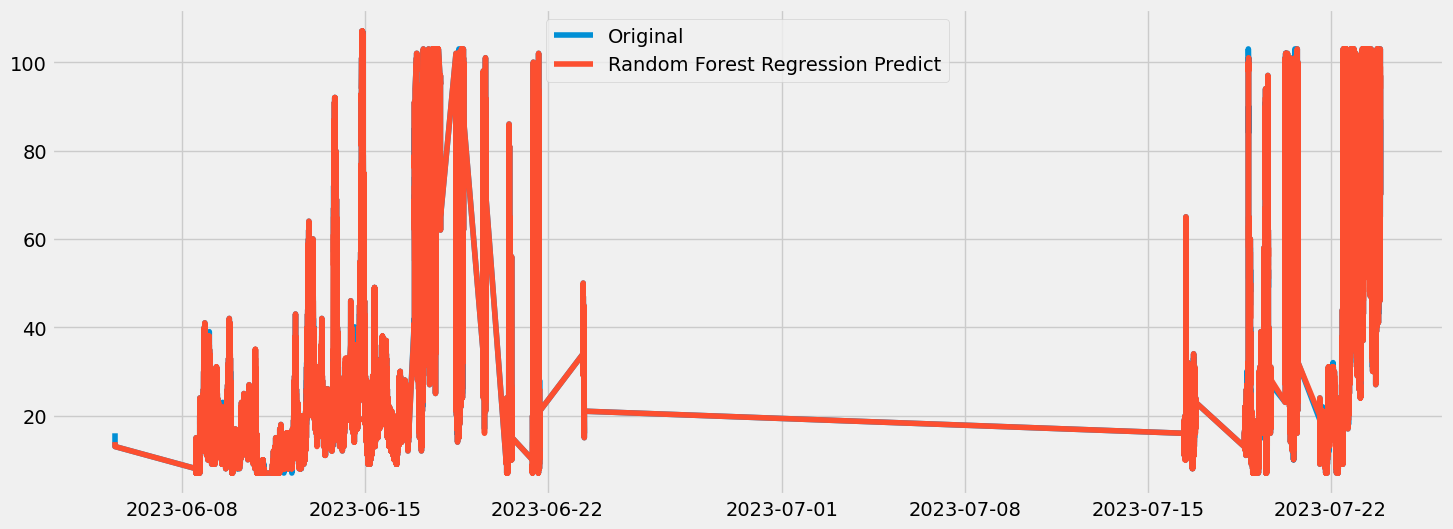

In [57]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM10.0"], label="Original")
ax.plot(df["rforest_reg_predict"], label="Random Forest Regression Predict")


ax.legend()

### Evaluation Metric

In [58]:
#  Mean Squared Error
rforest_reg_mse = mean_squared_error(df["PM10.0"], df["rforest_reg_predict"])
rforest_reg_mse

0.20488003628508392

In [59]:
#Root Mean Squared Error
rforest_reg_rmse = np.sqrt(mean_squared_error(df["PM10.0"], df["rforest_reg_predict"]))
rforest_reg_rmse

0.45263675975895273

In [60]:
# Mean Absolute Error
rforest_reg_mae = mean_absolute_error(df["PM10.0"], df["rforest_reg_predict"])
rforest_reg_mae

0.09251927645082679

In [61]:
rforest_reg_err_eval = [rforest_reg_mse, rforest_reg_rmse, rforest_reg_mae]
rforest_reg_err_eval

[0.20488003628508392, 0.45263675975895273, 0.09251927645082679]

## Overall Minimum Error Evaluation of Models

In [62]:
# error_evals = [xgb_err_eval,
#                 linreg_err_eval,
#                 tree_err_eval,
#                 tree_reg_err_eval,
#                 rforest_err_eval,
#                 rforest_reg_err_eval]


error_evals = {"Xgb Reg": xgb_err_eval,
            "Linear Reg": linreg_err_eval,
            "DecisionTreeClassifier": tree_err_eval,
            "DecisionTreeRegressor": tree_reg_err_eval,
            "RandomForestClassifier": rforest_err_eval,
            "RandomForestRegressor": rforest_reg_err_eval}

error_evals

{'Xgb Reg': [0.9202931633016207, 0.9593191144252369, 0.7241438825896171],
 'Linear Reg': [1.068354668520946, 1.0336124363226993, 0.7579808922243453],
 'DecisionTreeClassifier': [0.22818090266833743,
  0.4776828473666785,
  0.10259761225697835],
 'DecisionTreeRegressor': [0.2290034670705176,
  0.47854306710108924,
  0.10285130034363205],
 'RandomForestClassifier': [0.20488003628508392,
  0.45263675975895273,
  0.09251927645082679],
 'RandomForestRegressor': [0.20488003628508392,
  0.45263675975895273,
  0.09251927645082679]}

In [63]:
# Finding the lowest error evaluations for trained models
def comp_val(sublist):
    return sublist[0]

min_error = min(error_evals, key=lambda key: comp_val(error_evals[key]))
print(f"Lowest error evaluation for trained models was {min_error}")

Lowest error evaluation for trained models was RandomForestClassifier
